In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import h5py
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


**I'm including random horizontal/vertical flips and random cropping. These augmentations are critical according to the SimCLR paper to generate different views of the same image for contrastive learning. The same transformation pipeline is used for both pretraining and fine-tuning.**

In [2]:
class RandomHorizontalFlipTensor(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, x):
        if random.random() < self.p:
            return torch.flip(x, dims=[2])
        return x

class RandomVerticalFlipTensor(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, x):
        if random.random() < self.p:
            return torch.flip(x, dims=[1])
        return x

class RandomCropTensor(object):
    def __init__(self, output_size):
        self.output_size = output_size
    def __call__(self, x):
        _, h, w = x.shape
        new_h, new_w = self.output_size
        if h == new_h and w == new_w:
            return x
        top = random.randint(0, h - new_h)
        left = random.randint(0, w - new_w)
        return x[:, top: top + new_h, left: left + new_w]

simclr_transform = transforms.Compose([
    RandomHorizontalFlipTensor(p=0.5),
    RandomVerticalFlipTensor(p=0.5),
    RandomCropTensor((112, 112)),
    transforms.Normalize(mean=[0.5]*8, std=[0.5]*8)
])
labelled_transform = simclr_transform

In [3]:
class UnlabelledDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_path = h5_path
        self.transform = transform
        self.h5_file = None 
        with h5py.File(self.h5_path, 'r') as f:
            self.length = f['jet'].shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.h5_file is None:
            self.h5_file = h5py.File(self.h5_path, 'r')
        image = self.h5_file['jet'][idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        # Generate two augmented views.
        view1 = self.transform(image) if self.transform else image
        view2 = self.transform(image) if self.transform else image
        return view1, view2

    def __del__(self):
        if self.h5_file is not None:
            self.h5_file.close()

unlabelled_h5_path = "/kaggle/input/data2-st/unlabelled2/content/Dataset_Specific_Unlabelled.h5"
unlabelled_dataset = UnlabelledDataset(h5_path=unlabelled_h5_path, transform=simclr_transform)
print("Unlabelled dataset size:", len(unlabelled_dataset))

BATCH_SZ_UNLABELLED = 8
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=BATCH_SZ_UNLABELLED, 
                               shuffle=True, drop_last=True, pin_memory=True)


Unlabelled dataset size: 60000



**In this cell, I have defined a custom ResNet15 backbone by modifying a ResNet18 model. The first convolution layer is adapted for 8-channel images, and I remove part of the last layer to create a smaller network (approximating ResNet15).The SimCLR model wraps this backbone with a projection head. The projection head maps the encoder's 512-dimensional features to a 256-dimensional latent space. This projection is necessary in contrastive learning, as it helps the network focus on useful representations. The NT-Xent loss is later used to train this model by comparing the similarity between augmented views.**


In [4]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

def get_resnet15():
    resnet15 = models.resnet18(pretrained=False)
    resnet15.conv1 = nn.Conv2d(8, 64, kernel_size=7, stride=2, padding=3, bias=False)
    resnet15.layer4 = nn.Sequential(*list(resnet15.layer4.children())[:1])
    resnet15.fc = Identity() 
    return resnet15

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super(SimCLR, self).__init__()
        self.linear_eval = linear_eval
        self.encoder = get_resnet15().to(DEVICE)
        self.projection = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256)
        ).to(DEVICE)
        
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0) 
        encoding = self.encoder(x)
        projection = self.projection(encoding)
        return projection

simclr_model = SimCLR().to(DEVICE)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



**here I'm pretraining the SimCLR model using the unlabelled dataset. The NT-Xent loss is used to train the model to bring augmented views of the same image closer in the latent space while pushing away representations of different images. The key idea is to learn representations that are invariant to augmentations. Two views of the same image (generated via the transformations) are processed through the encoder and projection head. Their similarity is measured and optimized with a contrastive loss.**


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
SimCLR Pretraining Epoch 1/10: 100%|██████████| 7500/7500 [09:53<00:00, 12.63it/s]


Epoch 1 completed in 9.896 mins, Avg Loss: 1.0157


SimCLR Pretraining Epoch 2/10: 100%|██████████| 7500/7500 [05:30<00:00, 22.71it/s]


Epoch 2 completed in 5.504 mins, Avg Loss: 0.9431


SimCLR Pretraining Epoch 3/10: 100%|██████████| 7500/7500 [04:14<00:00, 29.45it/s]


Epoch 3 completed in 4.244 mins, Avg Loss: 0.9288


SimCLR Pretraining Epoch 4/10: 100%|██████████| 7500/7500 [04:09<00:00, 30.04it/s]


Epoch 4 completed in 4.162 mins, Avg Loss: 0.9212


SimCLR Pretraining Epoch 6/10: 100%|██████████| 7500/7500 [03:43<00:00, 33.49it/s]


Epoch 6 completed in 3.732 mins, Avg Loss: 0.9133


SimCLR Pretraining Epoch 7/10: 100%|██████████| 7500/7500 [03:37<00:00, 34.44it/s]


Epoch 7 completed in 3.629 mins, Avg Loss: 0.9109


SimCLR Pretraining Epoch 8/10: 100%|██████████| 7500/7500 [03:35<00:00, 34.77it/s]


Epoch 8 completed in 3.595 mins, Avg Loss: 0.9099


SimCLR Pretraining Epoch 9/10: 100%|██████████| 7500/7500 [03:33<00:00, 35.07it/s]


Epoch 9 completed in 3.565 mins, Avg Loss: 0.9071


SimCLR Pretraining Epoch 10/10: 100%|██████████| 7500/7500 [03:33<00:00, 35.12it/s]


Epoch 10 completed in 3.559 mins, Avg Loss: 0.9064
SimCLR Pretraining completed and weights saved as simclr_pretrained_resnet15.pth.


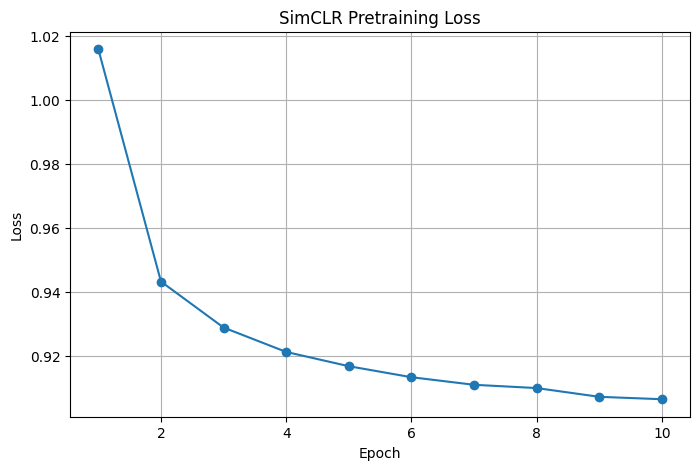

In [5]:


def simclr_loss(features, temperature=0.5):
    device = features.device
    batch_size = features.shape[0] // 2  
    features = F.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T)
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
    similarity_matrix = similarity_matrix.masked_fill(mask, -float('inf'))

    similarity_matrix /= temperature

    targets = torch.cat([torch.arange(batch_size, device=device) + batch_size,
                         torch.arange(batch_size, device=device)])
    loss = F.cross_entropy(similarity_matrix, targets)
    return loss


optimizer = optim.Adam(simclr_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

pretrain_epochs = 10
temperature = 0.5

pretrain_losses = []

simclr_model.train()
for epoch in range(pretrain_epochs):
    t0 = time.time()
    running_loss = 0.0
    num_batches = 0
    for view1, view2 in tqdm(unlabelled_loader, desc=f"SimCLR Pretraining Epoch {epoch+1}/{pretrain_epochs}"):
        view1, view2 = view1.to(DEVICE), view2.to(DEVICE)
        # Pass list of two views.
        projections = simclr_model([view1, view2])
        loss = simclr_loss(projections, temperature=temperature)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_batches += 1
        
    avg_loss = running_loss / num_batches
    pretrain_losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed in {(time.time()-t0)/60:.3f} mins, Avg Loss: {avg_loss:.4f}")
    scheduler.step(avg_loss)
    torch.cuda.empty_cache()

torch.save(simclr_model.state_dict(), "simclr_pretrained_resnet15.pth")
print("SimCLR Pretraining completed and weights saved as simclr_pretrained_resnet15.pth.")

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(range(1, pretrain_epochs+1), pretrain_losses, marker='o')
plt.title("SimCLR Pretraining Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [6]:
class H5LabelledDataset(Dataset):
    def __init__(self, h5_path, transform=None):
        self.h5_path = h5_path
        self.transform = transform
        self.h5_file = None
        with h5py.File(self.h5_path, 'r') as f:
            self.length = f['jet'].shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if self.h5_file is None:
            self.h5_file = h5py.File(self.h5_path, 'r')
        image = self.h5_file['jet'][idx]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform is not None:
            image = self.transform(image)
        y = int(self.h5_file['Y'][idx][0])
        m = self.h5_file['m'][idx]
        pt = self.h5_file['pT'][idx]
        reg_target = torch.tensor(np.concatenate([m, pt], axis=0), dtype=torch.float32)
        return image, y, reg_target

    def __del__(self):
        if self.h5_file is not None:
            self.h5_file.close()
labelled_h5_path = "/kaggle/input/data2-st/specific-labelled2/content/Dataset_Specific_labelled_full_only_for_2i.h5"
full_labelled_dataset = H5LabelledDataset(h5_path=labelled_h5_path, transform=labelled_transform)
print("Total labelled dataset size:", len(full_labelled_dataset))
total_len = len(full_labelled_dataset)
train_len = int(0.8 * total_len)
test_len = total_len - train_len
train_dataset, test_dataset = random_split(full_labelled_dataset, [train_len, test_len])
print("Train samples:", len(train_dataset), "Test samples:", len(test_dataset))

BATCH_SZ_LABELLED = 64
train_loader_labelled = DataLoader(train_dataset, batch_size=BATCH_SZ_LABELLED, shuffle=True, drop_last=True, pin_memory=True)
test_loader_labelled = DataLoader(test_dataset, batch_size=BATCH_SZ_LABELLED, shuffle=False, drop_last=False, pin_memory=True)


Total labelled dataset size: 10000
Train samples: 8000 Test samples: 2000


In [7]:

class FineTuneClassifier(nn.Module):
    def __init__(self, simclr_model, num_classes=2):
        super().__init__()
        # Load pretrained encoder and remove projection head
        self.encoder = simclr_model.encoder  
        self.linear = nn.Linear(512, num_classes)
        
    def forward(self, x):
        features = self.encoder(x)
        return self.linear(features)

class FineTuneRegressor(nn.Module):
    def __init__(self, simclr_model, out_dim=2):
        super().__init__()
        self.encoder = simclr_model.encoder
        self.regressor = nn.Linear(512, out_dim)
        
    def forward(self, x):
        features = self.encoder(x)
        return self.regressor(features)


**Two learning rates are used: a lower learning rate for the encoder (to avoid large updates) and a higher rate for the new classification head.**

<ipython-input-8-7b9dfd4b6642>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_weights = torch.load("simclr_pretrained_resnet15.pth", map_location=DEVICE)
Classi

Epoch 1 Classification Loss: 0.6973


Classification Epoch 2/20: 100%|██████████| 125/125 [00:50<00:00,  2.46it/s]


Epoch 2 Classification Loss: 0.6692


Classification Epoch 3/20: 100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Epoch 3 Classification Loss: 0.6659


Classification Epoch 4/20: 100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Epoch 4 Classification Loss: 0.6621


Classification Epoch 5/20: 100%|██████████| 125/125 [00:17<00:00,  7.35it/s]


Epoch 5 Classification Loss: 0.6612


Classification Epoch 6/20: 100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Epoch 6 Classification Loss: 0.6603


Classification Epoch 7/20: 100%|██████████| 125/125 [00:17<00:00,  7.33it/s]


Epoch 7 Classification Loss: 0.6601


Classification Epoch 8/20: 100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Epoch 8 Classification Loss: 0.6577


Classification Epoch 9/20: 100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Epoch 9 Classification Loss: 0.6559


Classification Epoch 10/20: 100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Epoch 10 Classification Loss: 0.6567


Classification Epoch 11/20: 100%|██████████| 125/125 [00:17<00:00,  7.35it/s]


Epoch 11 Classification Loss: 0.6544


Classification Epoch 12/20: 100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Epoch 12 Classification Loss: 0.6528


Classification Epoch 13/20: 100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Epoch 13 Classification Loss: 0.6532


Classification Epoch 14/20: 100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Epoch 14 Classification Loss: 0.6520


Classification Epoch 15/20: 100%|██████████| 125/125 [00:17<00:00,  7.31it/s]


Epoch 15 Classification Loss: 0.6495


Classification Epoch 16/20: 100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Epoch 16 Classification Loss: 0.6494


Classification Epoch 17/20: 100%|██████████| 125/125 [00:17<00:00,  7.31it/s]


Epoch 17 Classification Loss: 0.6474


Classification Epoch 18/20: 100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Epoch 18 Classification Loss: 0.6462


Classification Epoch 19/20: 100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Epoch 19 Classification Loss: 0.6452


Classification Epoch 20/20: 100%|██████████| 125/125 [00:17<00:00,  7.35it/s]


Epoch 20 Classification Loss: 0.6421


<ipython-input-8-7b9dfd4b6642>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y, dtype=torch.long).to(DEVICE)


Fine-tuned (Pretrained) Classification Accuracy: 64.65%


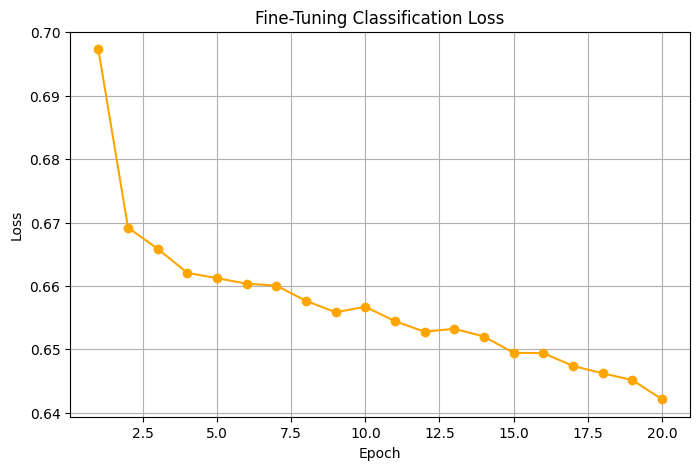

In [8]:

pretrained_weights = torch.load("simclr_pretrained_resnet15.pth", map_location=DEVICE)
simclr_model.load_state_dict(pretrained_weights)

clf_model = FineTuneClassifier(simclr_model).to(DEVICE)
criterion_clf = nn.CrossEntropyLoss()

optimizer_clf = optim.Adam([
    {'params': clf_model.encoder.parameters(), 'lr': 1e-5},
    {'params': clf_model.linear.parameters(), 'lr': 1e-4}
])

scheduler_clf = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_clf, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs_cls = 20 

cls_losses = []
clf_model.train()
for epoch in range(num_epochs_cls):
    running_loss = 0.0
    for images, y, _ in tqdm(train_loader_labelled, desc=f"Classification Epoch {epoch+1}/{num_epochs_cls}"):
        images = images.to(DEVICE)
        labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
        outputs = clf_model(images)
        loss = criterion_clf(outputs, labels)
        optimizer_clf.zero_grad()
        loss.backward()
        optimizer_clf.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_labelled)
    cls_losses.append(avg_loss)
    scheduler_clf.step(avg_loss)
    print(f"Epoch {epoch+1} Classification Loss: {avg_loss:.4f}")

clf_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, y, _ in test_loader_labelled:
        images = images.to(DEVICE)
        labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
        outputs = clf_model(images)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
clf_acc = 100 * correct / total
print(f"Fine-tuned (Pretrained) Classification Accuracy: {clf_acc:.2f}%")

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs_cls+1), cls_losses, marker='o', color='orange')
plt.title("Fine-Tuning Classification Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Regression Epoch 5/20: 100%|██████████| 125/125 [00:17<00:00,  7.18it/s]


Epoch 5 Regression Loss: 150978.7370


Regression Epoch 6/20: 100%|██████████| 125/125 [00:17<00:00,  7.11it/s]


Epoch 6 Regression Loss: 150299.1296


Regression Epoch 7/20: 100%|██████████| 125/125 [00:17<00:00,  7.08it/s]


Epoch 7 Regression Loss: 149567.9655


Regression Epoch 8/20: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s]


Epoch 8 Regression Loss: 148790.4956


Regression Epoch 9/20: 100%|██████████| 125/125 [00:17<00:00,  7.09it/s]


Epoch 9 Regression Loss: 147963.2714


Regression Epoch 10/20: 100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Epoch 10 Regression Loss: 147101.4756


Regression Epoch 11/20: 100%|██████████| 125/125 [00:17<00:00,  7.09it/s]


Epoch 11 Regression Loss: 146185.5391


Regression Epoch 12/20: 100%|██████████| 125/125 [00:17<00:00,  7.11it/s]


Epoch 12 Regression Loss: 145230.5359


Regression Epoch 13/20: 100%|██████████| 125/125 [00:17<00:00,  7.06it/s]


Epoch 13 Regression Loss: 144231.4893


Regression Epoch 14/20: 100%|██████████| 125/125 [00:17<00:00,  7.13it/s]


Epoch 14 Regression Loss: 143226.9588


Regression Epoch 15/20: 100%|██████████| 125/125 [00:17<00:00,  7.03it/s]


Epoch 15 Regression Loss: 142210.0816


Regression Epoch 16/20: 100%|██████████| 125/125 [00:17<00:00,  7.14it/s]


Epoch 16 Regression Loss: 141139.7742


Regression Epoch 17/20: 100%|██████████| 125/125 [00:17<00:00,  7.22it/s]


Epoch 17 Regression Loss: 140052.5574


Regression Epoch 18/20: 100%|██████████| 125/125 [00:17<00:00,  7.04it/s]


Epoch 18 Regression Loss: 138928.8890


Regression Epoch 19/20: 100%|██████████| 125/125 [00:17<00:00,  7.19it/s]


Epoch 19 Regression Loss: 137797.1689


Regression Epoch 20/20: 100%|██████████| 125/125 [00:17<00:00,  7.01it/s]


Epoch 20 Regression Loss: 136691.5895
Fine-tuned (Pretrained) Regression MSE: 135212.7487


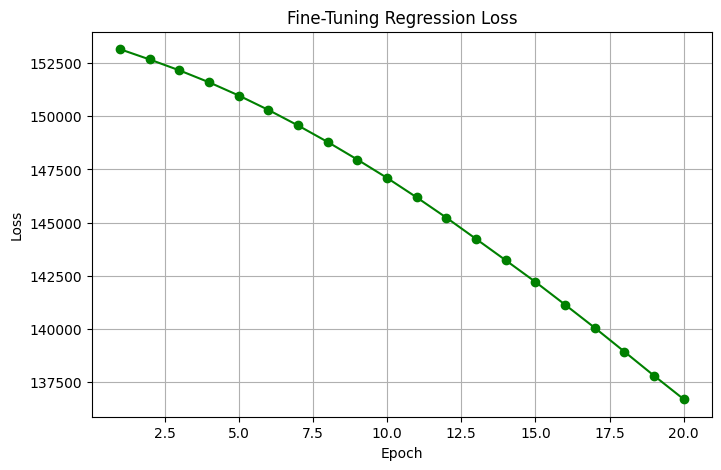

In [9]:

reg_model = FineTuneRegressor(simclr_model).to(DEVICE)
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam([
    {'params': reg_model.encoder.parameters(), 'lr': 1e-5},
    {'params': reg_model.regressor.parameters(), 'lr': 1e-4}
])

scheduler_reg = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode='min', factor=0.5, patience=2, verbose=True)

num_epochs_reg = 20

reg_losses = []
reg_model.train()
for epoch in range(num_epochs_reg):
    running_loss = 0.0
    for images, _, reg_targets in tqdm(train_loader_labelled, desc=f"Regression Epoch {epoch+1}/{num_epochs_reg}"):
        images = images.to(DEVICE)
        reg_targets = reg_targets.to(DEVICE)
        outputs = reg_model(images)
        loss = criterion_reg(outputs, reg_targets)
        optimizer_reg.zero_grad()
        loss.backward()
        optimizer_reg.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_labelled)
    reg_losses.append(avg_loss)
    scheduler_reg.step(avg_loss)
    print(f"Epoch {epoch+1} Regression Loss: {avg_loss:.4f}")

reg_model.eval()
total_loss = 0.0
with torch.no_grad():
    for images, _, reg_targets in test_loader_labelled:
        images = images.to(DEVICE)
        reg_targets = reg_targets.to(DEVICE)
        outputs = reg_model(images)
        loss = criterion_reg(outputs, reg_targets)
        total_loss += loss.item() * images.size(0)
avg_mse = total_loss / len(test_dataset)
print(f"Fine-tuned (Pretrained) Regression MSE: {avg_mse:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs_reg+1), reg_losses, marker='o', color='green')
plt.title("Fine-Tuning Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


**i have implemented a vgg 11 model for comparison.**

In [10]:
class VGG(nn.Module):
    def __init__(self, num_classes=2, regression_out=2, mode='classification'):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(8, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3,3))
        self.mode = mode
        if mode == 'classification':
            self.classifier = nn.Sequential(
                nn.Linear(512 * 3 * 3, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, num_classes)
            )
        else:  
            self.regressor = nn.Sequential(
                nn.Linear(512 * 3 * 3, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, regression_out)
            )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if self.mode == 'classification':
            x = self.classifier(x)
        else:
            x = self.regressor(x)
        return x


In [11]:
vgg_classifier = VGG(num_classes=2, mode='classification').to(DEVICE)
criterion_vgg_clf = nn.CrossEntropyLoss()
optimizer_vgg_clf = optim.Adam(vgg_classifier.parameters(), lr=1e-3)
num_epochs_vgg_cls = 10

vgg_cls_losses = []
vgg_classifier.train()
for epoch in range(num_epochs_vgg_cls):
    running_loss = 0.0
    for images, y, _ in tqdm(train_loader_labelled, desc=f"VGG Classification Epoch {epoch+1}/{num_epochs_vgg_cls}"):
        images = images.to(DEVICE)
        labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
        outputs = vgg_classifier(images)
        loss = criterion_vgg_clf(outputs, labels)
        optimizer_vgg_clf.zero_grad()
        loss.backward()
        optimizer_vgg_clf.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_labelled)
    vgg_cls_losses.append(avg_loss)
    print(f"Epoch {epoch+1} VGG Classification Loss: {avg_loss:.4f}")

vgg_classifier.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, y, _ in test_loader_labelled:
        images = images.to(DEVICE)
        labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
        outputs = vgg_classifier(images)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
vgg_cls_acc = 100 * correct / total
print(f"Scratch VGG Classification Accuracy: {vgg_cls_acc:.2f}%")
torch.save(vgg_classifier.state_dict(), "scratch_vgg_classifier.pth")



VGG Classification Epoch 1/10:   0%|          | 0/125 [00:00<?, ?it/s]<ipython-input-11-822824c94d8f>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y, dtype=torch.long).to(DEVICE)
VGG Classification Epoch 1/10: 100%|██████████| 125/125 [00:27<00:00,  4.47it/s]


Epoch 1 VGG Classification Loss: 1.5522


VGG Classification Epoch 2/10: 100%|██████████| 125/125 [00:27<00:00,  4.54it/s]


Epoch 2 VGG Classification Loss: 0.6955


VGG Classification Epoch 3/10: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]


Epoch 3 VGG Classification Loss: 0.6930


VGG Classification Epoch 4/10: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]


Epoch 4 VGG Classification Loss: 0.6936


VGG Classification Epoch 5/10: 100%|██████████| 125/125 [00:27<00:00,  4.56it/s]


Epoch 5 VGG Classification Loss: 0.6932


VGG Classification Epoch 6/10: 100%|██████████| 125/125 [00:27<00:00,  4.56it/s]


Epoch 6 VGG Classification Loss: 0.6933


VGG Classification Epoch 7/10: 100%|██████████| 125/125 [00:27<00:00,  4.56it/s]


Epoch 7 VGG Classification Loss: 0.6934


VGG Classification Epoch 8/10: 100%|██████████| 125/125 [00:27<00:00,  4.53it/s]


Epoch 8 VGG Classification Loss: 0.6931


VGG Classification Epoch 9/10: 100%|██████████| 125/125 [00:27<00:00,  4.54it/s]


Epoch 9 VGG Classification Loss: 0.6932


VGG Classification Epoch 10/10: 100%|██████████| 125/125 [00:27<00:00,  4.56it/s]
<ipython-input-11-822824c94d8f>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y, dtype=torch.long).to(DEVICE)


Epoch 10 VGG Classification Loss: 0.6931
Scratch VGG Classification Accuracy: 52.85%


In [16]:

vgg_regressor = VGG(regression_out=2, mode='regression').to(DEVICE)
criterion_vgg_reg = nn.MSELoss()
optimizer_vgg_reg = optim.Adam(vgg_regressor.parameters(), lr=1e-3)
num_epochs_vgg_reg = 10

vgg_reg_losses = []
vgg_regressor.train()
for epoch in range(num_epochs_vgg_reg):
    running_loss = 0.0
    for images, _, reg_targets in tqdm(train_loader_labelled, desc=f"VGG Regression Epoch {epoch+1}/{num_epochs_vgg_reg}"):
        images = images.to(DEVICE)
        reg_targets = reg_targets.to(DEVICE)
        outputs = vgg_regressor(images)
        loss = criterion_vgg_reg(outputs, reg_targets)
        optimizer_vgg_reg.zero_grad()
        loss.backward()
        optimizer_vgg_reg.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader_labelled)
    vgg_reg_losses.append(avg_loss)
    print(f"Epoch {epoch+1} VGG Regression Loss: {avg_loss:.4f}")

vgg_regressor.eval()
total_loss = 0.0
with torch.no_grad():
    for images, _, reg_targets in test_loader_labelled:
        images = images.to(DEVICE)
        reg_targets = reg_targets.to(DEVICE)
        outputs = vgg_regressor(images)
        loss = criterion_vgg_reg(outputs, reg_targets)
        total_loss += loss.item() * images.size(0)
vgg_avg_mse = total_loss / len(test_dataset)
print(f"Scratch VGG Regression MSE: {vgg_avg_mse:.4f}")
torch.save(vgg_regressor.state_dict(), "scratch_vgg_regressor.pth")


VGG Regression Epoch 1/10: 100%|██████████| 125/125 [00:27<00:00,  4.50it/s]


Epoch 1 VGG Regression Loss: 46530.4767


VGG Regression Epoch 2/10: 100%|██████████| 125/125 [00:28<00:00,  4.44it/s]


Epoch 2 VGG Regression Loss: 9406.1688


VGG Regression Epoch 3/10: 100%|██████████| 125/125 [00:27<00:00,  4.53it/s]


Epoch 3 VGG Regression Loss: 8690.0128


VGG Regression Epoch 4/10: 100%|██████████| 125/125 [00:27<00:00,  4.51it/s]


Epoch 4 VGG Regression Loss: 8385.3887


VGG Regression Epoch 5/10: 100%|██████████| 125/125 [00:27<00:00,  4.48it/s]


Epoch 5 VGG Regression Loss: 7920.7742


VGG Regression Epoch 6/10: 100%|██████████| 125/125 [00:27<00:00,  4.52it/s]


Epoch 6 VGG Regression Loss: 8148.6947


VGG Regression Epoch 7/10: 100%|██████████| 125/125 [00:27<00:00,  4.50it/s]


Epoch 7 VGG Regression Loss: 7836.9689


VGG Regression Epoch 8/10: 100%|██████████| 125/125 [00:27<00:00,  4.51it/s]


Epoch 8 VGG Regression Loss: 7697.7678


VGG Regression Epoch 9/10: 100%|██████████| 125/125 [00:27<00:00,  4.49it/s]


Epoch 9 VGG Regression Loss: 7724.3109


VGG Regression Epoch 10/10: 100%|██████████| 125/125 [00:27<00:00,  4.48it/s]


Epoch 10 VGG Regression Loss: 7495.5629
Scratch VGG Regression MSE: 6104.1699


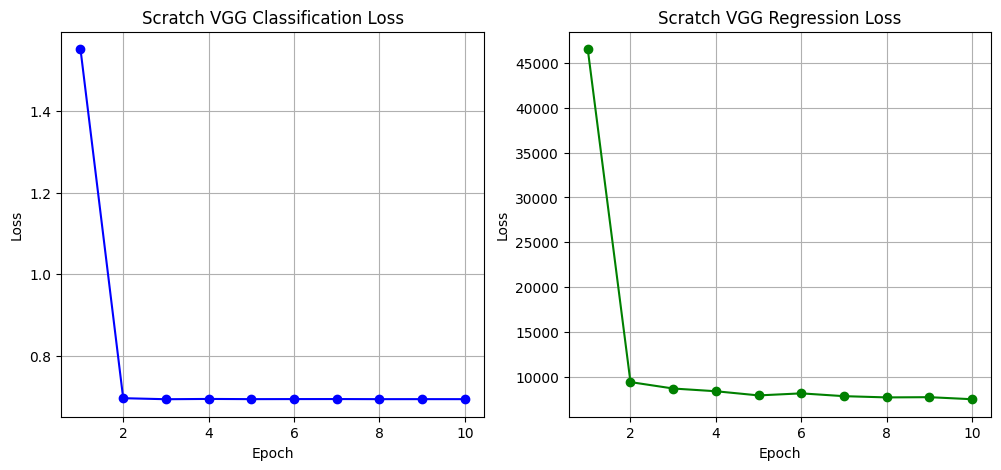

Scratch VGG Classification Accuracy: 52.85%
Scratch VGG Regression MSE: 6104.1699


In [17]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs_vgg_cls+1), vgg_cls_losses, marker='o', color='blue')
plt.title("Scratch VGG Classification Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs_vgg_reg+1), vgg_reg_losses, marker='o', color='green')
plt.title("Scratch VGG Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print(f"Scratch VGG Classification Accuracy: {vgg_cls_acc:.2f}%")
print(f"Scratch VGG Regression MSE: {vgg_avg_mse:.4f}")


In [18]:
torch.save(clf_model.state_dict(), "finetuned_classifier.pth")
torch.save(reg_model.state_dict(), "finetuned_regressor.pth")

torch.save(vgg_classifier.state_dict(), "scratch_vgg_classifier.pth")
torch.save(vgg_regressor.state_dict(), "scratch_vgg_regressor.pth")

print(f"Fine-tuned Classification Accuracy: {clf_acc:.2f}%")
print(f"Fine-tuned Regression MSE: {avg_mse:.4f}")
print(f"Scratch VGG Classification Accuracy: {vgg_cls_acc:.2f}%")
print(f"Scratch VGG Regression MSE: {vgg_avg_mse:.4f}")




Fine-tuned Classification Accuracy: 64.65%
Fine-tuned Regression MSE: 135212.7487
Scratch VGG Classification Accuracy: 52.85%
Scratch VGG Regression MSE: 6104.1699


In [20]:
!zip -r models.zip simclr_pretrained_resnet15.pth finetuned_classifier.pth finetuned_regressor.pth scratch_vgg_classifier.pth scratch_vgg_regressor.pth

updating: finetuned_classifier.pth (deflated 7%)
updating: finetuned_regressor.pth (deflated 7%)
updating: scratch_vgg_classifier.pth (deflated 8%)
updating: scratch_vgg_regressor.pth (deflated 8%)
  adding: simclr_pretrained_resnet15.pth (deflated 7%)
